In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

# (ds_train, ds_test), ds_info = tfds.load(
#     'cats_vs_dogs',
#     split=['train', 'test'],
#     shuffle_files=True,
#     with_info=True,
# )
ds_train, ds_info = tfds.load(
    'cats_vs_dogs',
    split='train[:80%]',
    shuffle_files=True,
    as_supervised = True,
    with_info=True,
)
ds_test, ds_info = tfds.load(
    'cats_vs_dogs',
    split='train[80%:]',
    shuffle_files=True,
    as_supervised = True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])    
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
        
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

2

In [9]:
ds_info.features["label"].names

['cat', 'dog']

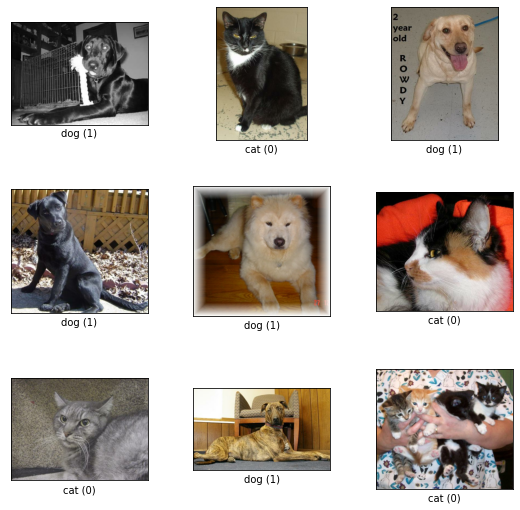

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

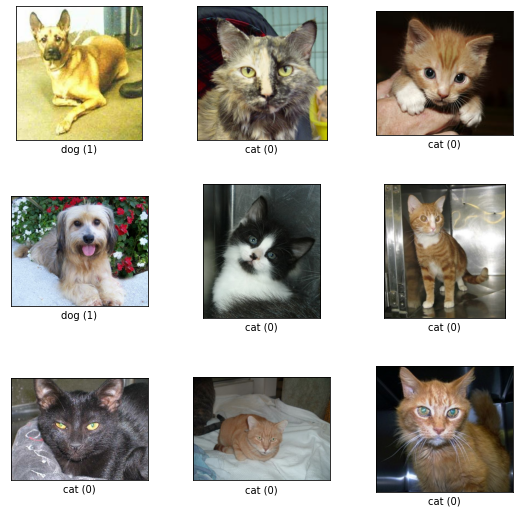

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

In [12]:
ds_train = apply_normalize_on_dataset(ds_train)

In [13]:
ds_test = apply_normalize_on_dataset(ds_test)

# vgg 블럭 생성

In [14]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [15]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [16]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


# vgg 빌더

In [17]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(224,224,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=2):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    
    
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [18]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)       0   

In [19]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)       0   

# resnet block

- is_50 = True --> resnet50 블록 사용 False --> resnet34 블록 사용
- is_plain = True --> skip connection 사용하지 않음

In [20]:
# function for building resnet Block

# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [21]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
resnet_block_output = build_resnet_block(resnet_input_layer)    # resnet 블록 생성

In [22]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv0 (Conv2D)           (None, 32, 32, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         block1_conv0[0][0]               
__________________________________________________________________________________________________
block1_1_conv0 (Conv2D)         (None, 32, 32, 64)   36928       batch_normalization[0][0]        
____________________________________________________________________________________________

# resnet block 빌더

In [23]:
# resnet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=2,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [24]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

resnet_34.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 832         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [25]:
resnet_50.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 112, 112, 64) 832         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 112, 112, 64) 256         conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [26]:
plain_resnet_34.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 112, 112, 64) 832         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 112, 112, 64) 256         conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [27]:
plain_resnet_50.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 112, 112, 64) 832         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 112, 112, 64) 256         conv2d_13[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_54[0][0]     
____________________________________________________________________________________________

# train vgg

In [28]:
BATCH_SIZE = 256
EPOCH = 20

In [29]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
72/72 [==============================] - 63s 533ms/step - loss: 0.8232 - accuracy: 0.5058 - val_loss: 0.6763 - val_accuracy: 0.5521
Epoch 2/20
72/72 [==============================] - 37s 515ms/step - loss: 0.6931 - accuracy: 0.5319 - val_loss: 0.6777 - val_accuracy: 0.6042
Epoch 3/20
72/72 [==============================] - 37s 518ms/step - loss: 0.6778 - accuracy: 0.5964 - val_loss: 0.6574 - val_accuracy: 0.5625
Epoch 4/20
72/72 [==============================] - 37s 520ms/step - loss: 0.6728 - accuracy: 0.5782 - val_loss: 0.6134 - val_accuracy: 0.6910
Epoch 5/20
72/72 [==============================] - 37s 522ms/step - loss: 0.6450 - accuracy: 0.6284 - val_loss: 0.6503 - val_accuracy: 0.6042
Epoch 6/20
72/72 [==============================] - 37s 521ms/step - loss: 0.6346 - accuracy: 0.6134 - val_loss: 0.6590 - val_accuracy: 0.5938
Epoch 7/20
72/72 [==============================] - 37s 521ms/step - loss: 0.6205 - accuracy: 0.6436 - val_loss: 0.6002 - val_accuracy: 0.6424

In [30]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
72/72 [==============================] - 48s 609ms/step - loss: 0.8320 - accuracy: 0.4904 - val_loss: 0.6880 - val_accuracy: 0.5590
Epoch 2/20
72/72 [==============================] - 44s 606ms/step - loss: 0.6943 - accuracy: 0.5305 - val_loss: 0.6955 - val_accuracy: 0.5139
Epoch 3/20
72/72 [==============================] - 44s 606ms/step - loss: 0.6832 - accuracy: 0.5447 - val_loss: 0.6738 - val_accuracy: 0.5694
Epoch 4/20
72/72 [==============================] - 44s 606ms/step - loss: 0.6773 - accuracy: 0.5825 - val_loss: 0.6480 - val_accuracy: 0.6146
Epoch 5/20
72/72 [==============================] - 44s 606ms/step - loss: 0.6793 - accuracy: 0.5831 - val_loss: 0.6535 - val_accuracy: 0.5729
Epoch 6/20
72/72 [==============================] - 44s 606ms/step - loss: 0.6582 - accuracy: 0.6168 - val_loss: 0.6586 - val_accuracy: 0.5972
Epoch 7/20
72/72 [==============================] - 44s 606ms/step - loss: 0.6661 - accuracy: 0.5761 - val_loss: 0.6155 - val_accuracy: 0.6875

# train resnet 34

In [31]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
72/72 [==============================] - 42s 252ms/step - loss: 2.4414 - accuracy: 0.5048 - val_loss: 0.8595 - val_accuracy: 0.5000
Epoch 2/20
72/72 [==============================] - 17s 243ms/step - loss: 2.0076 - accuracy: 0.5099 - val_loss: 1.1359 - val_accuracy: 0.4861
Epoch 3/20
72/72 [==============================] - 17s 243ms/step - loss: 1.5408 - accuracy: 0.6108 - val_loss: 1.3819 - val_accuracy: 0.5104
Epoch 4/20
72/72 [==============================] - 17s 243ms/step - loss: 1.6439 - accuracy: 0.5775 - val_loss: 0.9050 - val_accuracy: 0.5278
Epoch 5/20
72/72 [==============================] - 18s 244ms/step - loss: 1.3843 - accuracy: 0.5767 - val_loss: 0.9587 - val_accuracy: 0.5764
Epoch 6/20
72/72 [==============================] - 18s 244ms/step - loss: 1.3440 - accuracy: 0.5819 - val_loss: 1.2502 - val_accuracy: 0.5625
Epoch 7/20
72/72 [==============================] - 18s 244ms/step - loss: 1.2055 - accuracy: 0.6133 - val_loss: 0.8252 - val_accuracy: 0.6250

# train resnet 50

In [32]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
72/72 [==============================] - 25s 251ms/step - loss: 2.2405 - accuracy: 0.4657 - val_loss: 2.1218 - val_accuracy: 0.4931
Epoch 2/20
72/72 [==============================] - 18s 245ms/step - loss: 1.4486 - accuracy: 0.5925 - val_loss: 3.0711 - val_accuracy: 0.4792
Epoch 3/20
72/72 [==============================] - 18s 244ms/step - loss: 1.6470 - accuracy: 0.5533 - val_loss: 2.4979 - val_accuracy: 0.5174
Epoch 4/20
72/72 [==============================] - 18s 244ms/step - loss: 1.3026 - accuracy: 0.6018 - val_loss: 0.7828 - val_accuracy: 0.5972
Epoch 5/20
72/72 [==============================] - 18s 244ms/step - loss: 1.3410 - accuracy: 0.5685 - val_loss: 0.9606 - val_accuracy: 0.5521
Epoch 6/20
72/72 [==============================] - 18s 245ms/step - loss: 1.2842 - accuracy: 0.5482 - val_loss: 1.1916 - val_accuracy: 0.5799
Epoch 7/20
72/72 [==============================] - 18s 244ms/step - loss: 1.1177 - accuracy: 0.6137 - val_loss: 1.3105 - val_accuracy: 0.5208

# train plain resnet 34

In [33]:
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

plain_histoty_34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
72/72 [==============================] - 25s 252ms/step - loss: 2.2648 - accuracy: 0.5309 - val_loss: 0.7630 - val_accuracy: 0.5208
Epoch 2/20
72/72 [==============================] - 18s 244ms/step - loss: 1.4728 - accuracy: 0.5828 - val_loss: 1.1615 - val_accuracy: 0.4896
Epoch 3/20
72/72 [==============================] - 18s 245ms/step - loss: 1.4311 - accuracy: 0.5941 - val_loss: 1.6308 - val_accuracy: 0.5035
Epoch 4/20
72/72 [==============================] - 18s 244ms/step - loss: 1.4873 - accuracy: 0.6002 - val_loss: 0.8566 - val_accuracy: 0.5312
Epoch 5/20
72/72 [==============================] - 18s 244ms/step - loss: 1.3412 - accuracy: 0.5742 - val_loss: 1.6359 - val_accuracy: 0.4965
Epoch 6/20
72/72 [==============================] - 18s 245ms/step - loss: 1.5021 - accuracy: 0.5485 - val_loss: 1.0406 - val_accuracy: 0.5451
Epoch 7/20
72/72 [==============================] - 18s 245ms/step - loss: 1.0869 - accuracy: 0.6338 - val_loss: 1.1406 - val_accuracy: 0.5486

# train plain resnet 50

In [34]:
plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

plain_histoty_50 = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
72/72 [==============================] - 25s 252ms/step - loss: 4.0008 - accuracy: 0.4027 - val_loss: 0.7749 - val_accuracy: 0.5660
Epoch 2/20
72/72 [==============================] - 18s 245ms/step - loss: 1.6296 - accuracy: 0.5688 - val_loss: 0.7985 - val_accuracy: 0.5382
Epoch 3/20
72/72 [==============================] - 18s 244ms/step - loss: 1.2397 - accuracy: 0.6125 - val_loss: 0.7209 - val_accuracy: 0.5625
Epoch 4/20
72/72 [==============================] - 18s 244ms/step - loss: 1.1801 - accuracy: 0.6110 - val_loss: 1.1001 - val_accuracy: 0.4965
Epoch 5/20
72/72 [==============================] - 18s 245ms/step - loss: 1.3370 - accuracy: 0.5547 - val_loss: 1.4314 - val_accuracy: 0.4896
Epoch 6/20
72/72 [==============================] - 18s 244ms/step - loss: 1.1112 - accuracy: 0.6345 - val_loss: 0.6831 - val_accuracy: 0.6250
Epoch 7/20
72/72 [==============================] - 18s 244ms/step - loss: 1.0327 - accuracy: 0.6059 - val_loss: 1.3312 - val_accuracy: 0.5451

# result

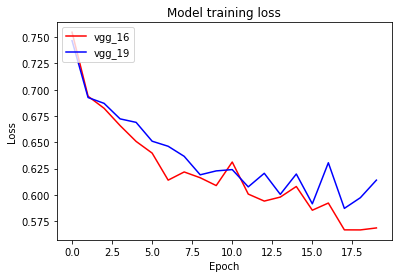

In [35]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

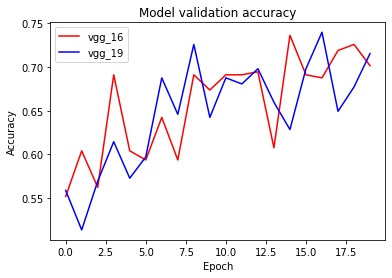

In [36]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

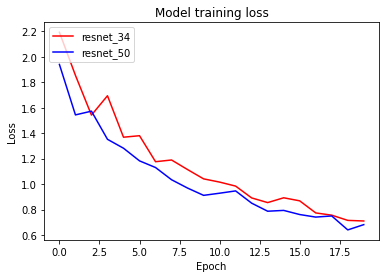

In [37]:
plt.plot(histoty_34.history['loss'], 'r')
plt.plot(histoty_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

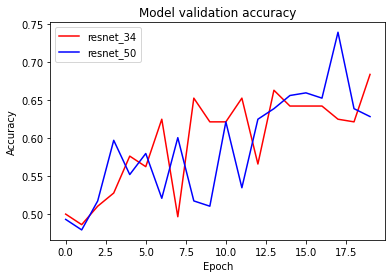

In [38]:
plt.plot(histoty_34.history['val_accuracy'], 'r')
plt.plot(histoty_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

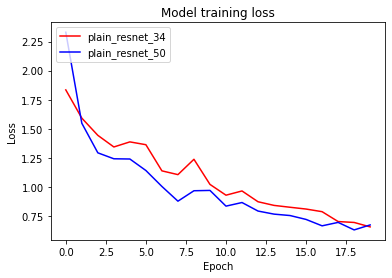

In [39]:
plt.plot(plain_histoty_34.history['loss'], 'r')
plt.plot(plain_histoty_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_resnet_34', 'plain_resnet_50'], loc='upper left')
plt.show()

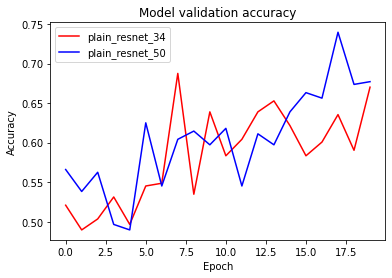

In [40]:
plt.plot(plain_histoty_34.history['val_accuracy'], 'r')
plt.plot(plain_histoty_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_resnet_34', 'plain_resnet_50'], loc='upper left')
plt.show()